In [ ]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            print(image.size[1], image.size[0])
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)
    
    name = image_path
    name.replace(".png",".mid")
    print(name)

    midi_stream.write('midi', 'composition.mid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(y/(1-y))

%matplotlib inline

path = '/content/drive/MyDrive/lofi_output'
os.getcwd()
img_list = os.listdir(path)
print(img_list)
print(np.size(img_list))

def access_images(img_list,path,length):
    pixels = []
    imgs = []
    for i in range(length):
        if 'png' in img_list[i]:
          try:
            img = Image.open(path+'/'+img_list[i],'r')
            img = img.convert('1')
            pix = np.array(img.getdata())
            pix = pix.astype('float32')
            pix /= 255.0
            pixels.append(pix.reshape(106,1000,1))
            imgs.append(img)
          except:
            pass
    return np.array(pixels),imgs

def show_image(pix_list):
    array = np.array(pix_list.reshape(106,106), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()
    
pixels,imgs = access_images(img_list,path,2873)
print(pixels.shape)

['Part I_Piano_0.png', 'Intervallo_Percussion_0.png', 'An Arrow In The Gale_Electric Guitar_0.png', 'I Saw Her Standing There As made famous by The Beatles_Soprano Saxophone_0.png', 'Gentle Touch_StringPad_0.png', 'KnoXVIlle Girl_Sampler_0.png', 'Bowery from Nashville Moon_Voice_0.png', 'Equinoxe Part 5_SynChoir_2.png', 'Dont Make Me Lonely Radio Mix_Fretless Bass_0.png', 'Axel F_StringInstrument_0.png', 'Send Me An Angel Alternate Mix_MELODY_1.png', 'Methmouth_StringInstrument_0.png', 'Just Be Simple Album Version_Piano_1.png', 'Axel F_Marimba_0.png', 'Evangeline Album_Sampler_0.png', 'Animals Wearing Clothes_vocal_2.png', 'Die Harmonie_Clars x3_4.png', 'Keiner kann von uns nach Morgen sehn_Track 10_0.png', 'Gidea Park_Acoustic Bass_1.png', 'Animals Wearing Clothes_Electric Guitar_1.png', 'Gamm-recomposé_Acoustic Guitar_0.png', 'I Saw Her Standing There As made famous by The Beatles_Clavichord_1.png', 'Labfunk_Percussion_1.png', 'Perfect_Sampler_0.png', 'KnoXVIlle Girl_Melody_0.png',

In [ ]:
np.unique(pixels)

array([0., 1.], dtype=float32)

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import tensorflow as tf

from IPython.display import clear_output
 

def define_discriminator(in_shape=(106, 106, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

 
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 53 * 53
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 53, 128)))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))
    return model
 
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # resize real samples to match the size of the fake samples
    X = tf.image.resize(X, (106, 106))
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            #clear_output()

latent_dim = 20
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(2873, 106, 1000, 1)
1/1 [==============================] - 10s 10s/step
>1, 1/287, d=0.681, g=0.791
1/1 [==============================] - 0s 39ms/step
>1, 2/287, d=0.650, g=0.857
1/1 [==============================] - 0s 39ms/step
>1, 3/287, d=0.623, g=0.910
1/1 [==============================] - 0s 41ms/step
>1, 4/287, d=0.597, g=0.942
1/1 [==============================] - 0s 39ms/step
>1, 5/287, d=0.580, g=0.924
1/1 [==============================] - 0s 39ms/step
>1, 6/287, d=0.555, g=0.927
1/1 [==============================] - 0s 40ms/step
>1, 7/287, d=0.539, g=0.967
1/1 [==============================] - 0s 39ms/step
>1, 8/287, d=0.525, g=1.021
1/1 [==============================] - 0s 42ms/step
>1, 9/287, d=0.508, g=1.080
1/1 [==============================] - 0s 40ms/step
>1, 10/287, d=0.493, g=1.144
1/1 [==============================] - 0s 41ms/step
>1, 11/287, d=0.472, g=1.213
1/1 [==============================] - 0s 39ms/step
>1, 12/287, d=0.461, g=1.283
1/1 [===========

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # generate points in the latent space
    x_input = np.random.randn(n_samples, latent_dim)
    return x_input



# load model
model = g_model
# generate images
# generate a new output with a random seed

# generate images
seed  = np.random.randint(0, 1000)
latent_points = generate_latent_points(latent_dim, 1, seed=seed)
# generate images
X = g_model.predict(latent_points)

array = np.array(X.reshape(106,106),dtype = np.uint8)
array*= 255
new_image = Image.fromarray(array,'L')
new_image = new_image.save('composition.png')

1/1 [==============================] - 0s 38ms/step


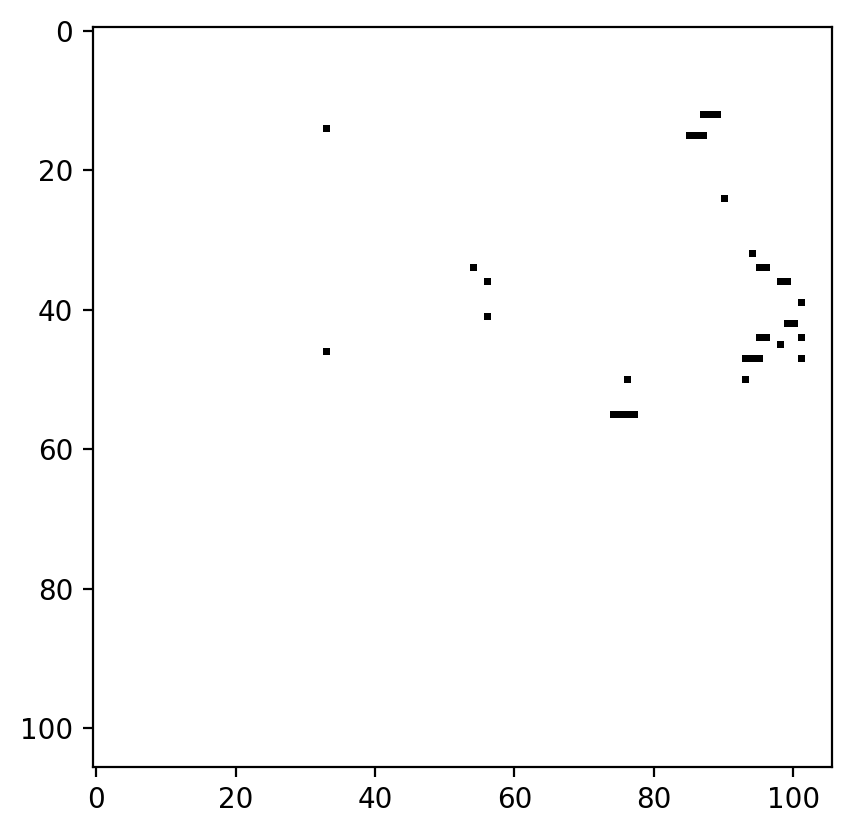

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(array.reshape(106,106), cmap='Greys',  interpolation='nearest')

plt.show()

In [ ]:
array.dtype

dtype('uint8')

In [ ]:
image2midi('composition.png')

106 106
composition.png


<ipython-input-1-1459b8b40f8f>:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)


In [ ]:
np.unique(array)

array([  0, 255], dtype=uint8)

In [ ]:
#!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!fluidsynth -ni font.sf2 composition.mid -F output.wav -r 44100 
from IPython.display import Audio
Audio('output.wav')

FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'output.wav'..


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 359552)            7550592   
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 359552)            0         
                                                                 
 reshape_1 (Reshape)         (None, 53, 53, 128)       0         
                                                                 
 dense_9 (Dense)             (None, 53, 53, 1024)      132096    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 53, 53, 1024)      0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 106, 106, 64)     1048640   
 ranspose)                                                       
                                                      